<div style="border:inset golden 2px; padding: 20px">

# Car Price Estimation
    
The "Non-Accident, Non-Painted" used car sales service is developing an application to attract new customers. The app allows users to quickly determine the market value of their car. We have historical data available, including technical characteristics, configurations, and prices of cars.

**Project Goal** - Build a model to estimate the price of a car.

The client emphasizes the following criteria:

* Prediction quality.
* Prediction speed.
* Training time.

**Research Plan**

The research will proceed through 4 stages:

- 1. Data Preparation.
   - 1.1. Handling missing values.
   - 1.2. Dealing with anomalies in columns.
- 2. Model Training.
   - 2.1. Preparing datasets for model training.
   - 2.2. Training models.
     - 2.2.1. LightGBM.
     - 2.2.2. XGBRegressor.
     - 2.2.3. CatBoost.
     - 2.2.4. LinearRegression.
- 3. Model Analysis.
- 4. Conclusion.

<img src="https://img.freepik.com/premium-vector/american-muscle-car-vector-monochrome-image-of-american-muscle-car-in-white-background-isolated_289688-398.jpg" width="500" height="500" alt="Car" />

In [1]:
%autosave 20

Autosaving every 20 seconds


## Data Preparation

Let's load the necessary libraries and open the data source file.

In [2]:
# Load libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

import lightgbm as lgb
import random
import time
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Configure parameters

sns.set_style("whitegrid")
RANDOM_STATE = 12345

In [4]:
# Read the file with data and save it to the "df" variable

df = pd.read_csv('./autos.csv')

Now i proceed to examining the available data.

In [5]:
# Display the first 5 rows of the dataframe

df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


According to the task requirements, I need features that characterize the technical characteristics, configurations, and prices of cars. Columns such as `DateCrawled`, `DateCreated`, `NumberOfPictures`, `PostalCode`, and `LastSeen` are not needed for this analysis and can be removed.

In [6]:
# Remove unnecessary columns

df = df.drop(columns=['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'])

In [7]:
# Display general information about the dataframe

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              354369 non-null  int64 
 1   VehicleType        316879 non-null  object
 2   RegistrationYear   354369 non-null  int64 
 3   Gearbox            334536 non-null  object
 4   Power              354369 non-null  int64 
 5   Model              334664 non-null  object
 6   Kilometer          354369 non-null  int64 
 7   RegistrationMonth  354369 non-null  int64 
 8   FuelType           321474 non-null  object
 9   Brand              354369 non-null  object
 10  Repaired           283215 non-null  object
dtypes: int64(5), object(6)
memory usage: 29.7+ MB


There are a total of 11 features and 354,369 instances in the dataset. The features have the correct data types, and there are missing values in the `VehicleType`, `Gearbox`, `Model`, `FuelType`, and `Repaired` columns.

In [8]:
# Display information about the features

df.describe(include='all')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
count,354369.000000,316879,354369.000000,334536,354369.000000,334664,354369.000000,354369.000000,321474,354369,283215
unique,NaN,8,NaN,2,NaN,250,NaN,NaN,7,40,2
top,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no
freq,NaN,91457,NaN,268251,NaN,29232,NaN,NaN,216352,77013,247161
mean,4416.656776,NaN,2004.234448,NaN,110.094337,NaN,128211.172535,5.714645,NaN,NaN,NaN
std,4514.158514,NaN,90.227958,NaN,189.850405,NaN,37905.341530,3.726421,NaN,NaN,NaN
min,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN
25%,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN
50%,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN
75%,6400.000000,NaN,2008.000000,NaN,143.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN


Based on the data indicators of std (standard deviation), min (minimum value), and max (maximum value) for all features, it can be observed that the values in the dataset have sufficient dispersion, and there are anomalies and outliers that need to be excluded from the data. Additionally, incorrect zero values in the `Price` and `Power` columns can be removed.

In [9]:
df.nunique()

Price                3731
VehicleType             8
RegistrationYear      151
Gearbox                 2
Power                 712
Model                 250
Kilometer              13
RegistrationMonth      13
FuelType                7
Brand                  40
Repaired                2
dtype: int64

The `RegistrationMonth` feature contains 13 unique values, including zeros, which is incorrect. To replace the zero values, we will write a function that returns random numbers from the range (1, 12).

In [10]:
# Create the zero_values function with the row parameter

def zero_values(row):
    month = row['RegistrationMonth']
    
    # Set a condition for non-zero data
    
    if month > 0:
        
        # In this case, the function returns the same number
        
        return month
    else:
        
        # For each zero cell, the function returns a random value from the range (0, 12)
        
        return random.randint(1,12)

In [11]:
# The apply() method applies the function to the values in the dataframe column 

df['RegistrationMonth'] = df.apply(zero_values, axis=1)

Let's look at the transformed data description in our dataset.

In [12]:
# Display information about the features

df.describe(include='all')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
count,354369.000000,316879,354369.000000,334536,354369.000000,334664,354369.000000,354369.000000,321474,354369,283215
unique,NaN,8,NaN,2,NaN,250,NaN,NaN,7,40,2
top,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no
freq,NaN,91457,NaN,268251,NaN,29232,NaN,NaN,216352,77013,247161
mean,4416.656776,NaN,2004.234448,NaN,110.094337,NaN,128211.172535,6.402070,NaN,NaN,NaN
std,4514.158514,NaN,90.227958,NaN,189.850405,NaN,37905.341530,3.361903,NaN,NaN,NaN
min,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,1.000000,NaN,NaN,NaN
25%,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,4.000000,NaN,NaN,NaN
50%,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN
75%,6400.000000,NaN,2008.000000,NaN,143.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN


After filling the zero values using the method of replacing them with a random value from the specified range, we managed to maintain the original distribution of features.

Let's examine the distribution of data in the numerical features.

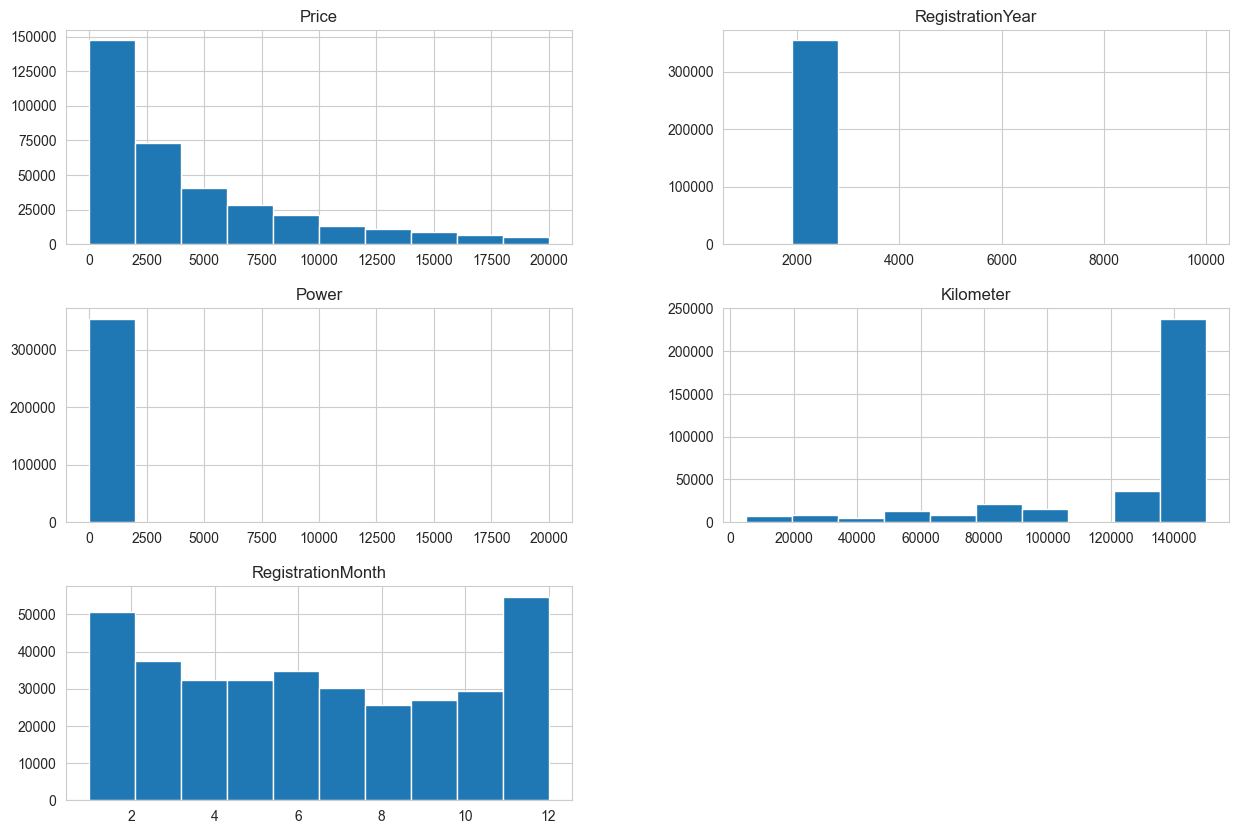

In [13]:
df.hist(figsize=(15, 10));

As the price of cars increases, the number of cars in observations decreases. The majority of cars have a mileage of over 140,000 km. Cars are predominantly registered at the beginning, middle, and end of the year.

Now, let's examine the distribution of data in individual categorical features.

In [14]:
df_categories = df[['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'Repaired']]

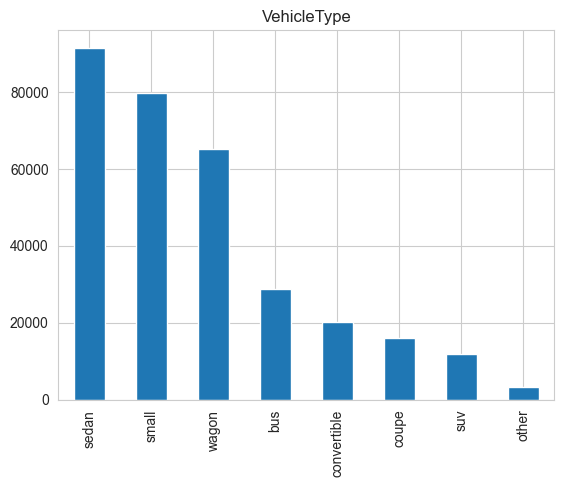

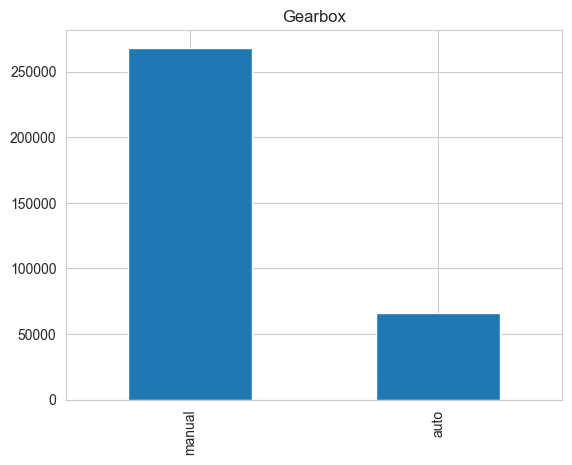

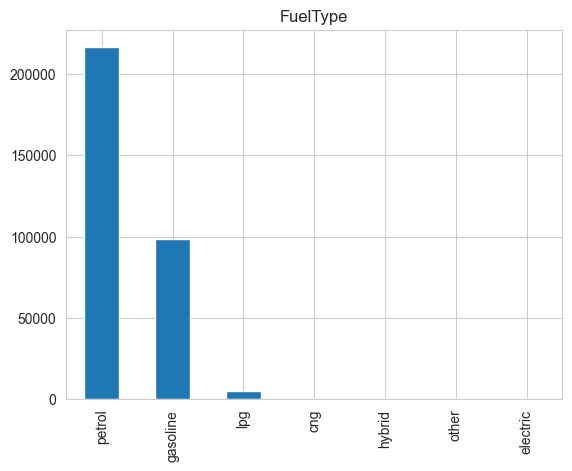

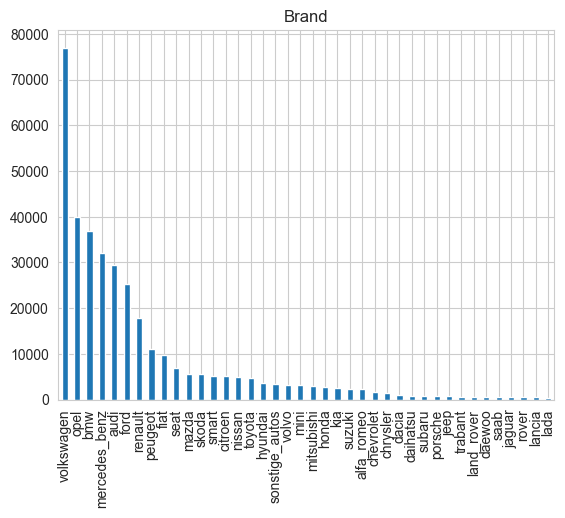

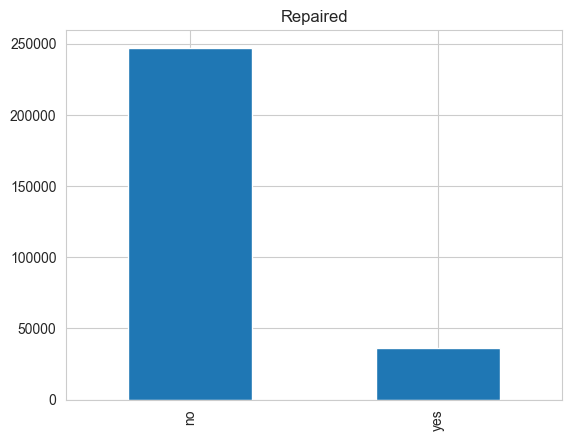

In [15]:
# To build histograms for each of the six categorical columns, I will write a loop

for col in df_categories:
    df_categories[col].value_counts().plot(kind='bar', title=col)
    plt.show()

* The majority of cars have a sedan body type, belong to the compact class, or are station wagons.
* There are more cars with a manual transmission than with an automatic transmission.
* Most drivers use gasoline, while gas is used nearly twice less.
* The majority of car listings belong to the Volkswagen brand, followed by Opel, BMW, Mercedes-Benz, and Audi in descending order.
* The majority of cars are not repaired.

Next, I will examine the presence of multicollinearity in the dataframe by visualizing the correlation matrix using a heatmap.

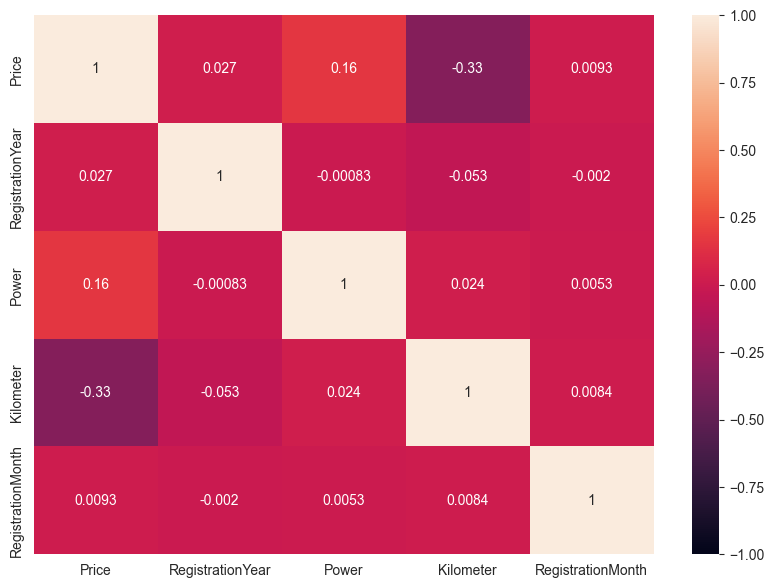

In [16]:
# Graph for the direct relationship between variables

fif, ax = plt.subplots(figsize=(10, 7))
_ = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, ax=ax)

No strong correlations between features have been identified.

### Handling Missing Values

Earlier, we have already identified missing values in specific columns. Let's display them as a percentage of the total sample.

In [17]:
# Calculate the average number of missing values in features

skips_df = pd.DataFrame(df.isna().mean()*100).round(2)

# Rename the column name with missing values in the table

skips_df.columns = ['Percentage of missing values (%)']

# Display the table on the screen

skips_df.sort_values(by='Percentage of missing values (%)', ascending=False).style.background_gradient('coolwarm')

,Percentage of missing values (%)
Repaired,20.080000
VehicleType,10.580000
FuelType,9.280000
Gearbox,5.600000
Model,5.560000
Price,0.000000
RegistrationYear,0.000000
Power,0.000000
Kilometer,0.000000
RegistrationMonth,0.000000


The highest number of missing data is related to the car repair status, body type, and fuel type. Several reasons could lead to missing data, such as data corruption, absence of data during certain time periods, or bias in the data collection process. Let's examine the table with empty values in these columns.

In [18]:
skips = df[df[['Repaired', 'VehicleType', 'FuelType', 'Gearbox', 'Model']].isna().any(axis=1)]
skips

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,6,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
8,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN
9,999,small,1998,manual,101,golf,150000,9,NaN,volkswagen,NaN
...,...,...,...,...,...,...,...,...,...,...,...
354357,1690,wagon,2004,manual,55,fabia,150000,4,petrol,skoda,NaN
354361,5250,NaN,2016,auto,150,159,150000,12,NaN,alfa_romeo,no
354364,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes
354365,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN


Now, let's see if the missing data appears randomly.

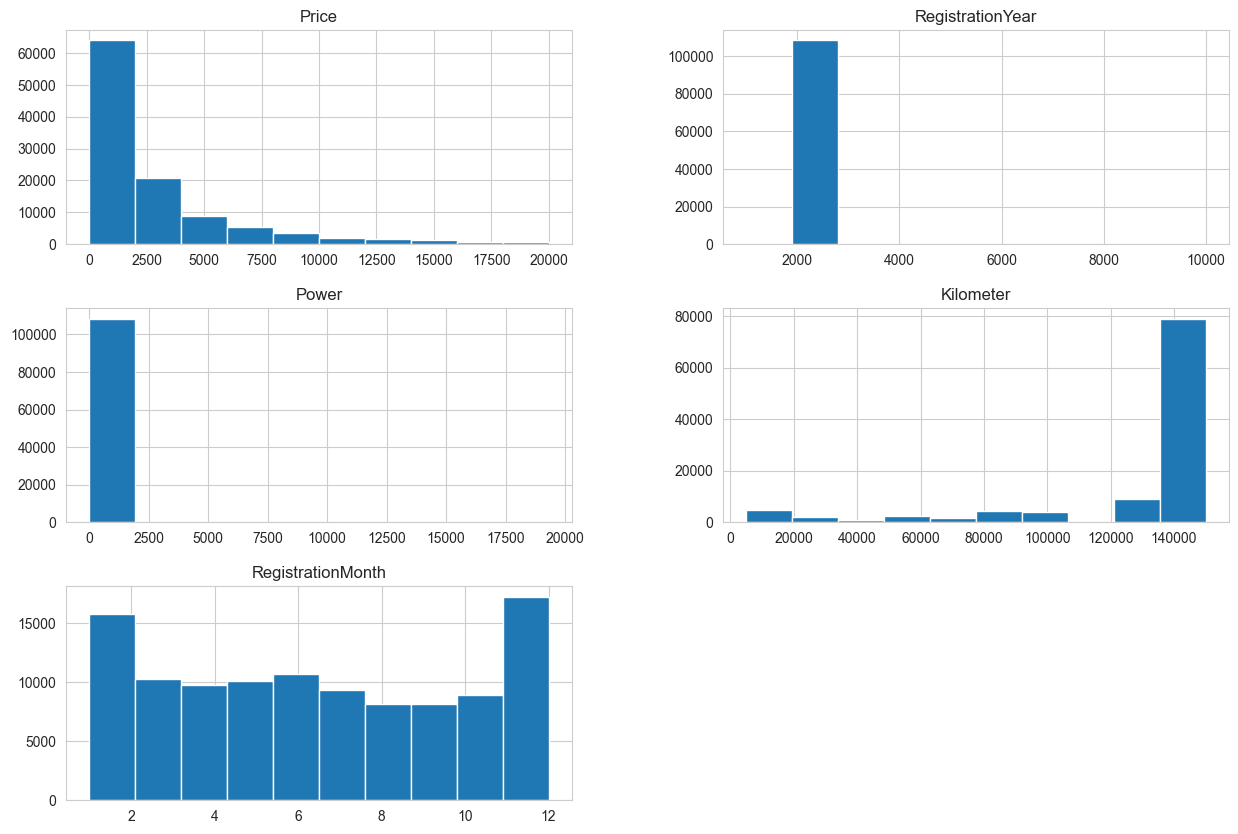

In [19]:
# Examine the distribution of features in the table with empty values

skips.hist(figsize=(15, 10));

Based on the obtained graphs, the probability of missing data is not the same for all data points, and there is no known data grouping where missing data is equally likely.

Filling the missing values with median values in this case will not be correct, as it may lead to biased estimates. Leaving cells blank is also not an option as it would hinder further analysis. Considering these circumstances, I will use an indicator value ("placeholder") for handling missing values. I will replace them using the fillna() method.

In [20]:
df = df.fillna('unknown')

Let's check for the presence of missing values after the transformations

In [21]:
# Count the number of missing values in the dataframe

df.isna().sum()

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
dtype: int64

The work on handling missing values is complete, and we can move on to the next stage.

### Handling Anomalies in Columns

We have already noticed the presence of anomalies in some features, including zero values in the `Price` and `Power` features earlier. Let's display the proportion of zero values in these features.

In [22]:
print('Percentage of zero values in the Price column', len(df[df['Price'] == 0]) / len(df['Price']) * 100)
print('Percentage of zero values in the Power column', len(df[df['Power'] == 0]) / len(df['Power']) * 100)

Percentage of zero values in the Price column 3.0397692800442475
Percentage of zero values in the Power column 11.351162206626427


I will clean these features from zero values.

In [23]:
df = df[(df['Price'] != 0) & (df['Power'] != 0)]

Next, I will write a function that will return the boundaries of normal values for the features.

In [24]:
# Create a function with one parameter

def normal_range(column):
    
    # Save the result of the describe() method to a variable
    
    value = df[column].describe()
    
    # Calculate the interquartile range
    
    iqr = value[6] - value[4]  
    
    # Range boundaries
    
    min = value[4] - 1.5 * iqr
    max = value[6] + 1.5 * iqr
    if min < value[3]: 
        min = value[3] 
    if max > value[7]: 
        max = value[7]
    
    # Plot a histogram within the obtained range
    
    df.plot(
        title = ('Histogram ' + column), 
        y = column,
        kind = 'hist', 
        bins = 50, 
        grid = True, 
        range = ((min), (max)), 
        figsize = (10, 5)
    )
    
    # Display the column characteristics
    
    print('Boundaries of normal values for the feature {}: ({:.2f}, {:.2f})'.format(
            column, 
            min,
            max))
    display(df[[column]].describe())
    return { 'column': column, 'normal_range': [min, max] }

I will create an array to store the results of the function's work.

In [25]:
normal_ranges = []

I will call the function for the `Price` feature and save it to the array.

Boundaries of normal values for the feature Price: (1.00, 15425.00)


,Price
count,307237.000000
mean,4809.847098
std,4586.524359
min,1.000000
25%,1300.000000
50%,3100.000000
75%,6950.000000
max,20000.000000


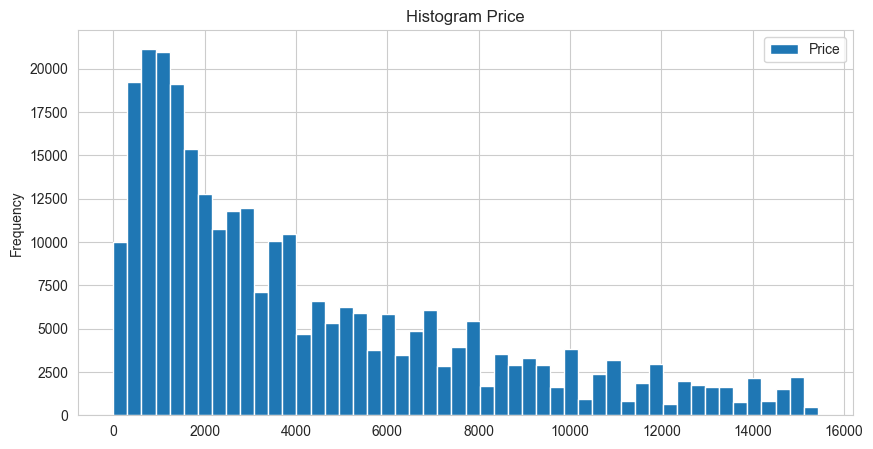

In [26]:
normal_ranges.append(normal_range('Price'))

For the `RegistrationYear` column:

Boundaries of normal values for the feature RegistrationYear: (1985.50, 2021.50)


,RegistrationYear
count,307237.000000
mean,2003.524549
std,33.641250
min,1000.000000
25%,1999.000000
50%,2003.000000
75%,2008.000000
max,9999.000000


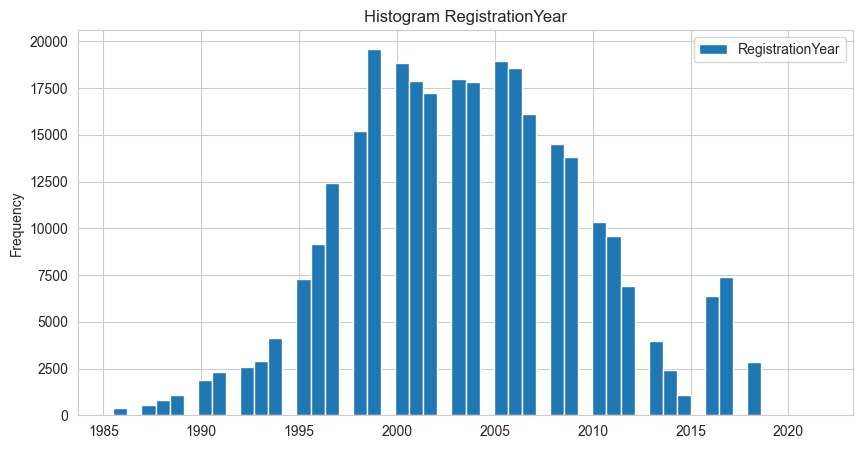

In [27]:
normal_ranges.append(normal_range('RegistrationYear'))

For the `Power` column:

Boundaries of normal values for the feature Power: (1.00, 262.50)


,Power
count,307237.000000
mean,124.136523
std,194.861419
min,1.000000
25%,75.000000
50%,110.000000
75%,150.000000
max,20000.000000


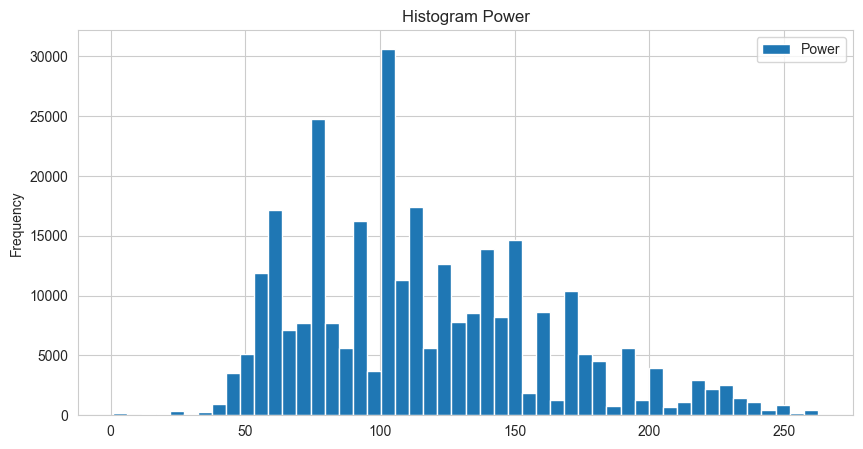

In [28]:
normal_ranges.append(normal_range('Power'))

I will exclude rows with anomalous data in the analyzed features:

In [29]:
# Display the size of the original sample

print(df.shape)

# Iterate through the features with normal values using a loop and exclude rows with anomalous data

for column_range in normal_ranges:
    df = df[(df[column_range['column']] >= column_range['normal_range'][0]) \
                                    & (df[column_range['column']] <= column_range['normal_range'][1])]
    
# Display the size of the sample after excluding anomalous values
    
print(df.shape)

(307237, 11)
(284768, 11)


Anomalies in the columns have been processed, and we can now proceed to prepare datasets for model training.

## Model Training

### Preparing datasets for model training

I will extract the categorical features.

In [30]:
categorical  = ['VehicleType', 'Gearbox', 'Model', 'RegistrationMonth', 'FuelType', 'Brand', 'Repaired']

I will create variables for features and target features.

In [31]:
features = df.drop(columns=['Price'])
target = df['Price']

I will split the dataset into training and testing sets using the train_test_split() function in an 80:20 ratio.

In [32]:
features_train, features_test, target_train, target_test = train_test_split(features, target, \
                                                                            test_size=0.2, \
                                                                            random_state=RANDOM_STATE)

The datasets are prepared, and now I can proceed to the next step - model training.

### Training models

I will train the gradient boosting models: LightGBM, XGBRegressor, CatBoost, and the linear model LinearRegression (sometimes simpler models work better).

Before starting the model training, it is necessary to encode the categorical features and scale the numerical features. For the linear regression model, I will use OneHotEncoder for encoding categorical features and StandardScaler for numerical features. For the gradient boosting models, I will use ordinal encoding for the Model feature, which has a large number of unique values, and OneHotEncoder for encoding the other categorical features.

In [33]:
features_train_boosting = features_train.copy()
features_test_boosting = features_test.copy()

In [34]:
features_train_linear = features_train.copy()
features_test_linear = features_test.copy()

I will save the categorical features separately for OneHotEncoder for the linear model and gradient boosting models.

In [35]:
# Categorical features for OHE linear

ohe_features_linear = features_train.copy().select_dtypes(include='object').columns.to_list()
print(ohe_features_linear)

# Categorical features for OHE boosting

ohe_features_boosting = ohe_features_linear.copy()
ohe_features_boosting.remove('Model')
ohe_features_boosting

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']


['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'Repaired']

I will save the numerical features for StandardScaler.

In [36]:
# Numerical features

num_features = features_train.select_dtypes(exclude='object').columns.to_list()
num_features

['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']

To transform our data, I will use the make_column_transformer function, which allows creating a composition of different transformations for different data columns.

In [37]:
col_transformer_boosting = make_column_transformer(
    (
        OneHotEncoder(handle_unknown='ignore'), 
        ohe_features_boosting
    ),
    (
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 
        ['Model']
    ),
    (
        StandardScaler(), 
        num_features
    ),
    remainder='passthrough'
)

#### LightGBM

In [38]:
# Create a dictionary of model parameters for GridSearchCV

params = {
    "lgbmregressor__learning_rate": [0.05, 0.1, 0.2],
    "lgbmregressor__n_estimators": [50, 70, 100]
}

Using the make_pipeline function, I will create a pipeline of passed transformation and model objects, and then perform a grid search for model and transformation hyperparameters.

In [39]:
# Create the LightGBM model

model_lgb = lgb.LGBMRegressor(random_state=RANDOM_STATE)

# Call the make_pipeline function

pipeline_lgb = make_pipeline(col_transformer_boosting, model_lgb)

# Use GridSearchCV to find the best parameters

grid = GridSearchCV(pipeline_lgb, param_grid=params, scoring="neg_root_mean_squared_error")
grid.fit(features_train_boosting, target_train)

# Display the best parameters

print("Best parameters:", grid.best_params_)

# Calculate the RMSE

rmse = grid.best_score_

# Time taken to train the model with the best parameters on the entire dataset

print("The number of seconds used for refitting the best model on the whole dataset: ", grid.refit_time_)

# Train the model with the best parameters

start_time = time.time()
model_lgb = lgb.LGBMRegressor(learning_rate=grid.best_params_["lgbmregressor__learning_rate"], 
                              n_estimators=grid.best_params_["lgbmregressor__n_estimators"],
                              random_state=RANDOM_STATE)
pipeline_lgb.fit(features_train_boosting, target_train)
training_time = time.time() - start_time

# Make predictions on the test set

start_time = time.time()
y_pred = pipeline_lgb.predict(features_test_boosting)
prediction_time = time.time() - start_time

# Display the results

print("Training time:", training_time)
print("Prediction time:", prediction_time)
print("RMSE:", rmse)

Training time: 1.0689959526062012
Prediction time: 0.09088826179504395
RMSE: -1373.3983719403227


#### XGBRegressor

In [40]:
# Create a dictionary of model parameters for GridSearchCV

param_grid = {
    "xgbregressor__n_estimators": [50, 100, 150],
    "xgbregressor__max_depth": [2, 4, 6]
}

In [41]:
# Create the XGBRegressor model

model_xgbr = XGBRegressor(random_state=RANDOM_STATE)

# Call the make_pipeline function

pipeline_xgbr = make_pipeline(col_transformer_boosting, model_xgbr)

# Use GridSearchCV to find the best parameters

grid_search = GridSearchCV(pipeline_xgbr, param_grid, scoring="neg_root_mean_squared_error")
grid_search.fit(features_train_boosting, target_train)

# Display the best parameters

print("Best parameters:", grid_search.best_params_)

# Calculate the RMSE

rmse_xgbr = grid_search.best_score_

# Time taken to train the model with the best parameters on the entire dataset

print("The number of seconds used for refitting the best model on the whole dataset: ", grid_search.refit_time_)

# Train the model with the best parameters

start_time = time.time()
model_xgbr = XGBRegressor(n_estimators=grid_search.best_params_["xgbregressor__n_estimators"], \
                          max_depth=grid_search.best_params_["xgbregressor__max_depth"], n_jobs=-1,
                          random_state=RANDOM_STATE)
pipeline_xgbr.fit(features_train_boosting, target_train)
training_time_xgbr = time.time() - start_time

# Make predictions on the test set

start_time = time.time()
y_pred_xgbr = pipeline_xgbr.predict(features_test_boosting)
prediction_time_xgbr = time.time() - start_time

# Display the results

print("Training time:", training_time_xgbr)
print("Prediction time:", prediction_time_xgbr)
print("RMSE:", rmse_xgbr)

Best parameters: {'xgbregressor__max_depth': 6, 'xgbregressor__n_estimators': 150}
The number of seconds used for refitting the best model on the whole dataset:  4.806525945663452
Training time: 3.31036114692688
Prediction time: 0.07216000556945801
RMSE: -1331.2267120231168


#### CatBoost

In [42]:
# Create a dictionary of model parameters for GridSearchCV

param_grid = {
    "catboostregressor__depth": [6, 8, 10],
    "catboostregressor__iterations": [10, 50, 70]
}

In [43]:
# Create the CatBoostRegressor model

model_catb = CatBoostRegressor(random_state=RANDOM_STATE)

# Call the make_pipeline function

pipeline_catb = make_pipeline(col_transformer_boosting, model_catb)

# Use GridSearchCV to find the best parameters

grid_search_catb = GridSearchCV(pipeline_catb, param_grid, cv=3, n_jobs=-1, verbose=1)
grid_search_catb.fit(features_train_boosting, target_train)

# Display the best parameters

print("Best parameters:", grid_search_catb.best_params_)

# Calculate the RMSE

rmse_catb = grid_search_catb.best_score_

# Time taken to train the model with the best parameters on the entire dataset

print("The number of seconds used for refitting the best model on the whole dataset: ", \
      grid_search_catb.refit_time_)

# Train the model with the best parameters

start_time = time.time()
model_catb = CatBoostRegressor(depth=grid_search_catb.best_params_["catboostregressor__depth"], \
                               iterations=grid_search_catb.best_params_["catboostregressor__iterations"],
                               random_state=RANDOM_STATE)
pipeline_catb.fit(features_train_boosting, target_train)
training_time_catb = time.time() - start_time

# Make predictions on the test set

start_time = time.time()
y_pred_catb = pipeline_catb.predict(features_test_boosting)
prediction_time_catb = time.time() - start_time

# Display the results

print("Training time:", training_time_catb)
print("Prediction time:", prediction_time_catb)
print("RMSE:", rmse_catb)

Training time: 4.800843715667725
Prediction time: 0.06978011131286621
RMSE: 0.8638921133348001


#### LinearRegression

In [44]:
col_transformer_linear = make_column_transformer(
    (
        OneHotEncoder(handle_unknown='ignore', sparse=False), 
        ohe_features_linear
    ),
    (
        StandardScaler(), 
        num_features
    ),
    remainder='passthrough',
    verbose_feature_names_out=False
)

In [45]:
# Create a dictionary of model parameters for GridSearchCV

param_grid_linear = {"linearregression__fit_intercept": [True, False]}

In [46]:
# Create the LinearRegression model

model_linear = LinearRegression()

# Call the make_pipeline function

pipeline_linear = make_pipeline(col_transformer_linear, model_linear)

# Use GridSearchCV to find the best parameters

grid_search_linear = GridSearchCV(pipeline_linear, param_grid_linear, scoring="neg_root_mean_squared_error")
grid_search_linear.fit(features_train_linear, target_train)

# Display the best parameters

print("Best parameters:", grid_search_linear.best_params_)

# Calculate the RMSE

rmse_linear = grid_search_linear.best_score_

# Train the model with the best parameters

start_time = time.time()
model_linear = LinearRegression(fit_intercept=grid_search_linear.best_params_["linearregression__fit_intercept"])
pipeline_linear.fit(features_train_boosting, target_train)
training_time_linear = time.time() - start_time

# Make predictions on the test set

start_time = time.time()
y_pred_linear = pipeline_linear.predict(features_test_boosting)
prediction_time_linear = time.time() - start_time

# Display the results

print("Training time:", training_time_linear)
print("Prediction time:", prediction_time_linear)
print("RMSE:", rmse_linear)

Best parameters: {'linearregression__fit_intercept': True}
Training time: 3.8146708011627197
Prediction time: 0.12286996841430664
RMSE: -3077912600.3881226


## Model Analysis

In [47]:
results = pd.DataFrame(
    {'Prediction Quality (RMSE)' : [rmse, rmse_xgbr, rmse_catb, rmse_linear],
     'Model Training Time' : [training_time, training_time_xgbr, training_time_catb, training_time_linear],
     'Model Prediction Time' : [prediction_time, prediction_time_xgbr, prediction_time_catb, \
                                prediction_time_linear]
    })

results.index = ['LightGBM', 'XGBRegressor', 'CatBoost', 'LinearRegression']

# Display the table on the screen

display(results)

,Prediction Quality (RMSE),Model Training Time,Model Prediction Time
LightGBM,-1.373398e+03,1.068996,0.090888
XGBRegressor,-1.331227e+03,3.310361,0.072160
CatBoost,8.638921e-01,4.800844,0.069780
LinearRegression,-3.077913e+09,3.814671,0.122870


## Conclusion

The following work has been conducted during the research:

✔️ Data was examined.

✔️ Non-informative columns were removed.

✔️ Missing values were filled.

✔️ Anomalous values in features were removed.

✔️ Datasets were prepared for model training.

✔️ Four models were trained: LightGBM, XGBRegressor, CatBoost, LinearRegression.

✔️ The training time, prediction time, and model quality were analyzed:
* For the **LightGBM** model, the model quality is (-1373), training time is 1.068, and prediction time is 0.0909.
* For the **XGBRegressor** model, the model quality is (-1331), training time is 3.310, and prediction time is 0.0722.
* For the **CatBoost** model, the model quality is 0.863, training time is 4.8, and prediction time is 0.0697.
* For the **LinearRegression** model, the model quality is (-3077912600), training time is 3.815, and prediction time is 0.1229.

Based on the obtained results, it can be concluded that **the best model** for determining the price of a car is **CatBoost**.